# Applying CLAY filtering and getting layout embeddings
**21/03/2022**

**Roberto Araya Day**

First, we apply CLAY label flags to the tree view hierarchy in the json files and remove the invalid nodes. Then, we train clustering algorithms with the changed view hierarchies from the screenshots of the most popular apps.

In [1]:
import os
import argparse
import json
import numpy as np
import torch
from s2v_code.Screen2Vec import Screen2Vec
from sentence_transformers import SentenceTransformer
from s2v_code.prediction import TracePredictor
from s2v_code.autoencoder import ScreenLayout, LayoutAutoEncoder
from s2v_code.UI_embedding.UI2Vec import HiddenLabelPredictorModel, UI2Vec
from s2v_code.dataset.playstore_scraper import get_app_description
from s2v_code.dataset.rico_utils import get_all_labeled_uis_from_rico_screen, ScreenInfo
from s2v_code.dataset.rico_dao import load_rico_screen_dict

import pandas
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from datetime import datetime
from itertools import compress
import random
import shutil


from google_play_scraper import app
import csv
import requests
import pandas as pd
from pathlib import Path
import umap.umap_ as umap


**Important Paths**

In [2]:
# path to important folders (may need to be changed)
screenvec = os.path.join(os.getcwd())
rico_dataset = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "unique_uis.tar", "unique_uis", "combined")
rico_popular_dataset = os.path.join(os.getcwd(), "json_files", "ratings_score_screens")

rico_layout_dataset = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "sem_annot", "semantic_annotations")

pretrained_model = os.path.join(screenvec, "s2v_pre-trained_model")
saved_tensors = os.path.join(os.getcwd(), "rico_tensors")
saved_popular_tensors = os.path.join(os.getcwd(), "popular_rico_tensors")

# path of the apps metadata
ui_details_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "ui_details.csv")
app_details_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "app_details.csv")

ui_names_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "ui_layout_vectors", "ui_layout_vectors", "ui_names.json")
layout_embedding_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "ui_layout_vectors", "ui_layout_vectors", "ui_vectors.npy")
clay_labels_csv = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "clay_labels.csv")
clay_label_map = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "label_map.txt")


# path of pre-trained model
gui_element_path = os.path.join(pretrained_model, "UI2Vec_model.ep120")
screen2vec_path = os.path.join(pretrained_model,"Screen2Vec_model_v4.ep120")
layout_encoder = os.path.join(pretrained_model,"layout_encoder.ep800")

# path of the saved plots and figures
saved_plt_path = os.path.join(os.getcwd(), "results")
cluster_examples = os.path.join(saved_plt_path, "cluster_examples")
cluster_examples_rico = os.path.join(os.getcwd(), "results", "cluster_examples_rico")
cluster_popular_examples_rico = os.path.join(os.getcwd(), "results", "cluster_popular_examples_rico")
clay_model_cluster_examples = os.path.join(os.getcwd(), "results", "clay_cluster_examples")

# path for saving the results
records = "records.txt"
records_path = os.path.join(saved_plt_path, records)

In [3]:
with open(clay_labels_csv) as csvfile:
    # maps the information in each row of the screenshot details to a dict
    reader = csv.DictReader(csvfile)
    counter = 0
    
    # iterate for each detail of screenshot 
    for row in reader:
        counter +=1
        screen_id, node_id, label = row.values()
        # get the app's name from the screenshot
        print(screen_id, node_id, label)
        
        screen_file = os.path.join(rico_dataset, f"{screen_id}.json")
        with open(screen_file) as f:
            rico_screen = json.load(f)
        #print(rico_screen["activity"]["root"]["children"])
        if counter == 5: break

25845 b6e43f6 -1
25845 eebc03b 0
25845 7950358 0
25845 4c03b1d 0
25845 c55d4de 1


## 1. Process RICO dataset using CLAY pipeline

We use the code from the repository and:
1. Read the files of the CLAY repository *clay_labels* and *label_map*.
2. Filter the invalid nodes and assign new labels.
3. Save the layout information with the new labels and boundary boxes of the components in '.xml' files.

In [4]:
#https://gist.github.com/dusskapark/c59eae6cae2b822bf7d133a2860c4c51#file-convert_rico_for_object_detection_based_on_clay-ipynb

import os
import json
from xml.etree.ElementTree import Element, SubElement
import csv
import sys

sys.setrecursionlimit(10**6)


def beautify(elem, indent=0):
    """
    Converts the XML tree to a string.

    :param elem: xml element
    :param indent: Indent Level to display in front
    """
    result0 = f"{'    ' * indent}<{elem.tag}>"
    
    # If there is a value in the tag, immediately print the value
    if elem.text is not None:
        result0 += elem.text + f"</{elem.tag}>\n"
    # 값이 없고 자식 노드가 있으면 재귀 호출로 출력합니다.
    # If the tag has no value and has child nodes, call the recursive function.
    else:
        result0 += "\n"
        for _child in elem:
            result0 += beautify(_child, indent + 1)
        result0 += f"{'    ' * indent}</{elem.tag}>\n"
    return result0


def labelinlist(screen_id, name):
    """
    clay_csv에 따라서 node를 분류합니다. 
    Filter nodes according to clay_csv
    """
    global resultdic

    for label in resultdic[screen_id]:
        if(label[0] == name):
            return True
    return False


def replace_label(screen_id, node):
    """
    label의 번호를 리턴합니다. 
    Returns the label number.
    """
    global resultdic
    global labeldict
    for label in resultdic[screen_id]:
        if(label[0] == node):
            label_map = int(label[1])
            return labeldict[label_map]
    return False


def recursive(screen_id, child, result_out):
    """
    원하는 역할을 하기 위해서 재귀호출을 할 수 있는 함수를 생성합니다.
    Create a function that makes a recursive call.
    """
    obj = Element("object")

        # Set bounds
    bounds = child['bounds']

        # Set difficult
    SubElement(obj, "difficult").text = '0'

    # Set bndbox
    bndbox = SubElement(obj, "bndbox")
    xmin = bounds[0]
    ymin = bounds[1]
    xmax = bounds[2]
    ymax = bounds[3]

    SubElement(bndbox, "xmin").text = str(xmin)
    SubElement(bndbox, "ymin").text = str(ymin)
    SubElement(bndbox, "xmax").text = str(xmax)
    SubElement(bndbox, "ymax").text = str(ymax)

    name = child['pointer']
    if(labelinlist(screen_id, name)):
        label_map = replace_label(screen_id, name)

        # Set name
        SubElement(obj, "name").text = label_map
        result_out.append(beautify(obj))

    # 생성한 object 태그를 문자열로 변환해서 추가합니다.
    # Convert the created object tag to a string and add it.
    if 'children' not in child:
        return

    # 자식 노드가 있는 경우 자식 노드에 대해 재귀 호출을 수행합니다.
    # If there is a child node, make a recursive call to the child node.
    for ch in child.get('children', []):
        if(ch != None):
            recursive(screen_id, ch, result_out)
        else:
            print(screen_id)
            print(ch,sep="\n")
            

def json2xml(screen_id, infile, outfile):
    """
    json2xml function
    param infile :
    ourfile :
    """

    result_out = []
    imgName = infile.replace("./combined/", "")
    imgName = imgName.replace("json", "jpg")

    # Read the file
    with open(infile, "r", encoding="UTF-8") as f:
        data = json.load(f)

    # 자식 노드에 대해 재귀 호출을 수행합니다.
    # Make a recursive call on child nodes.
    for child in data['activity']['root'].get('children', []):
        recursive(screen_id, child, result_out)

    # 그리고 해당 결과를 파일로 저장합니다.
    # And save the result to the XML file.
    with open(outfile, "w", encoding="UTF-8") as f:
        f.write("".join("<annotation><folder />"))
        f.write("".join("<filename>" + imgName + "</filename>\n"
                        "<path>" + imgName + "</path>\n" +
                        "<source><database>RICO</database></source><size><width>1440</width><height>2560</height><depth>3</depth></size><segmented>0</segmented>"))
        f.write("".join(result_out))
        f.write("".join("</annotation>"))


def readcsv(filename):
    """
    {screen_id:[[name0,id0]...],}
    """
    result = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')

        for row in reader:
            result.append(row)

            # print(row)
    del result[0]

    resultdic = {}
    for row in result:
        if row[0] in resultdic.keys():
            resultdic[row[0]].append([row[1], row[2]])
        else:
            resultdic[row[0]] = [[row[1], row[2]]]

    return resultdic


def readtxt(filename):
    """
    [{num}][{label}]
    """
    result = {}
    with open(filename, newline='') as f:
        while True:
            line = f.readline()
            if(not line):
                break
            num, label = line.split(':')
            num = int(num)
            label = label.strip()
            # print(f'[{num}][{label}]')
            result[num] = label
    return result


def main():
    """
    메인 함수
    The main function 
    """
    global resultdic
    global labeldict
    # print(files)

    resultdic = readcsv(clay_labels_csv)
    labeldict = readtxt(clay_label_map)

    data_path = './xml-full/'
    if not os.path.exists(data_path):
        os.mkdir(data_path)

    files = os.listdir(rico_dataset)
    print(len(files))
    counter = 0
    for infile in files:
        screen_id = infile.replace('.json', '').strip()
        print(screen_id)
        selected_screen = resultdic.get(screen_id)
        #print(selected_screen)
        if selected_screen == None:
            print(screen_id+" is not exist!")   
        else:
            counter+=1
            infile_b = os.path.join(rico_dataset, f'{infile}')
            outfile = os.path.join(os.getcwd(), "xml-full", infile.replace("json", "xml")) 
            json2xml(screen_id, infile_b, outfile)
    print(counter)

if __name__ == "__main__":
    main()

132522
0.jpg
0.jpg is not exist!
0
0 is not exist!
1.jpg
1.jpg is not exist!
1
1 is not exist!
10.jpg
10.jpg is not exist!
10
100.jpg
100.jpg is not exist!
100
1000.jpg
1000.jpg is not exist!
1000
10000.jpg
10000.jpg is not exist!
10000
10002.jpg
10002.jpg is not exist!
10002
10003.jpg
10003.jpg is not exist!
10003
10003 is not exist!
10004.jpg
10004.jpg is not exist!
10004
10005.jpg
10005.jpg is not exist!
10005
10008.jpg
10008.jpg is not exist!
10008
10008 is not exist!
1001.jpg
1001.jpg is not exist!
1001
10010.jpg
10010.jpg is not exist!
10010
10011.jpg
10011.jpg is not exist!
10011
10012.jpg
10012.jpg is not exist!
10012
10013.jpg
10013.jpg is not exist!
10013
10014.jpg
10014.jpg is not exist!
10014
10015.jpg
10015.jpg is not exist!
10015
10016.jpg
10016.jpg is not exist!
10016
10017.jpg
10017.jpg is not exist!
10017
10018.jpg
10018.jpg is not exist!
10018
10019.jpg
10019.jpg is not exist!
10019
10019 is not exist!
1002.jpg
1002.jpg is not exist!
1002
10020.jpg
10020.jpg is not ex

10192.jpg
10192.jpg is not exist!
10192
10193.jpg
10193.jpg is not exist!
10193
10194.jpg
10194.jpg is not exist!
10194
10195.jpg
10195.jpg is not exist!
10195
10196.jpg
10196.jpg is not exist!
10196
10197.jpg
10197.jpg is not exist!
10197
10198.jpg
10198.jpg is not exist!
10198
10199.jpg
10199.jpg is not exist!
10199
102.jpg
102.jpg is not exist!
102
1020.jpg
1020.jpg is not exist!
1020
10200.jpg
10200.jpg is not exist!
10200
10201.jpg
10201.jpg is not exist!
10201
10201 is not exist!
10202.jpg
10202.jpg is not exist!
10202
10203.jpg
10203.jpg is not exist!
10203
10204.jpg
10204.jpg is not exist!
10204
10205.jpg
10205.jpg is not exist!
10205
10206.jpg
10206.jpg is not exist!
10206
10207.jpg
10207.jpg is not exist!
10207
10208.jpg
10208.jpg is not exist!
10208
10209.jpg
10209.jpg is not exist!
10209
1021.jpg
1021.jpg is not exist!
1021
10210.jpg
10210.jpg is not exist!
10210
10211.jpg
10211.jpg is not exist!
10211
10212.jpg
10212.jpg is not exist!
10212
10213.jpg
10213.jpg is not exist

10413.jpg
10413.jpg is not exist!
10413
10414.jpg
10414.jpg is not exist!
10414
10415.jpg
10415.jpg is not exist!
10415
10416.jpg
10416.jpg is not exist!
10416
10417.jpg
10417.jpg is not exist!
10417
10418.jpg
10418.jpg is not exist!
10418
10419.jpg
10419.jpg is not exist!
10419
1042.jpg
1042.jpg is not exist!
1042
10420.jpg
10420.jpg is not exist!
10420
10421.jpg
10421.jpg is not exist!
10421
10421 is not exist!
10422.jpg
10422.jpg is not exist!
10422
10423.jpg
10423.jpg is not exist!
10423
10424.jpg
10424.jpg is not exist!
10424
10425.jpg
10425.jpg is not exist!
10425
10426.jpg
10426.jpg is not exist!
10426
10427.jpg
10427.jpg is not exist!
10427
10428.jpg
10428.jpg is not exist!
10428
10429.jpg
10429.jpg is not exist!
10429
1043.jpg
1043.jpg is not exist!
1043
1043 is not exist!
10430.jpg
10430.jpg is not exist!
10430
10431.jpg
10431.jpg is not exist!
10431
10431 is not exist!
10432.jpg
10432.jpg is not exist!
10432
10433.jpg
10433.jpg is not exist!
10433
10433 is not exist!
10434.j

1064.jpg
1064.jpg is not exist!
1064
10640.jpg
10640.jpg is not exist!
10640
10641.jpg
10641.jpg is not exist!
10641
10642.jpg
10642.jpg is not exist!
10642
10643.jpg
10643.jpg is not exist!
10643
10644.jpg
10644.jpg is not exist!
10644
10645.jpg
10645.jpg is not exist!
10645
10646.jpg
10646.jpg is not exist!
10646
10647.jpg
10647.jpg is not exist!
10647
10648.jpg
10648.jpg is not exist!
10648
10649.jpg
10649.jpg is not exist!
10649
1065.jpg
1065.jpg is not exist!
1065
10650.jpg
10650.jpg is not exist!
10650
10651.jpg
10651.jpg is not exist!
10651
10652.jpg
10652.jpg is not exist!
10652
10653.jpg
10653.jpg is not exist!
10653
10653 is not exist!
10654.jpg
10654.jpg is not exist!
10654
10655.jpg
10655.jpg is not exist!
10655
10656.jpg
10656.jpg is not exist!
10656
10657.jpg
10657.jpg is not exist!
10657
10658.jpg
10658.jpg is not exist!
10658
10659.jpg
10659.jpg is not exist!
10659
1066.jpg
1066.jpg is not exist!
1066
10660.jpg
10660.jpg is not exist!
10660
10661.jpg
10661.jpg is not ex

1084.jpg
1084.jpg is not exist!
1084
10840.jpg
10840.jpg is not exist!
10840
10841.jpg
10841.jpg is not exist!
10841
10842.jpg
10842.jpg is not exist!
10842
10843.jpg
10843.jpg is not exist!
10843
10844.jpg
10844.jpg is not exist!
10844
10845.jpg
10845.jpg is not exist!
10845
10846.jpg
10846.jpg is not exist!
10846
10847.jpg
10847.jpg is not exist!
10847
10848.jpg
10848.jpg is not exist!
10848
10849.jpg
10849.jpg is not exist!
10849
1085.jpg
1085.jpg is not exist!
1085
1085 is not exist!
10850.jpg
10850.jpg is not exist!
10850
10851.jpg
10851.jpg is not exist!
10851
10852.jpg
10852.jpg is not exist!
10852
10853.jpg
10853.jpg is not exist!
10853
10854.jpg
10854.jpg is not exist!
10854
10855.jpg
10855.jpg is not exist!
10855
10856.jpg
10856.jpg is not exist!
10856
10857.jpg
10857.jpg is not exist!
10857
10858.jpg
10858.jpg is not exist!
10858
10859.jpg
10859.jpg is not exist!
10859
1086.jpg
1086.jpg is not exist!
1086
10860.jpg
10860.jpg is not exist!
10860
10861.jpg
10861.jpg is not exi

11047.jpg
11047.jpg is not exist!
11047
11048.jpg
11048.jpg is not exist!
11048
11049.jpg
11049.jpg is not exist!
11049
1105.jpg
1105.jpg is not exist!
1105
11050.jpg
11050.jpg is not exist!
11050
11051.jpg
11051.jpg is not exist!
11051
11052.jpg
11052.jpg is not exist!
11052
11053.jpg
11053.jpg is not exist!
11053
11054.jpg
11054.jpg is not exist!
11054
11055.jpg
11055.jpg is not exist!
11055
11056.jpg
11056.jpg is not exist!
11056
11057.jpg
11057.jpg is not exist!
11057
11058.jpg
11058.jpg is not exist!
11058
11059.jpg
11059.jpg is not exist!
11059
1106.jpg
1106.jpg is not exist!
1106
11060.jpg
11060.jpg is not exist!
11060
11061.jpg
11061.jpg is not exist!
11061
11062.jpg
11062.jpg is not exist!
11062
11063.jpg
11063.jpg is not exist!
11063
11064.jpg
11064.jpg is not exist!
11064
11065.jpg
11065.jpg is not exist!
11065
11066.jpg
11066.jpg is not exist!
11066
11067.jpg
11067.jpg is not exist!
11067
11068.jpg
11068.jpg is not exist!
11068
11069.jpg
11069.jpg is not exist!
11069
1107.j

11242.jpg
11242.jpg is not exist!
11242
11246.jpg
11246.jpg is not exist!
11246
1125.jpg
1125.jpg is not exist!
1125
11258.jpg
11258.jpg is not exist!
11258
11259.jpg
11259.jpg is not exist!
11259
1126.jpg
1126.jpg is not exist!
1126
11260.jpg
11260.jpg is not exist!
11260
11261.jpg
11261.jpg is not exist!
11261
11262.jpg
11262.jpg is not exist!
11262
11263.jpg
11263.jpg is not exist!
11263
11264.jpg
11264.jpg is not exist!
11264
11265.jpg
11265.jpg is not exist!
11265
11266.jpg
11266.jpg is not exist!
11266
11267.jpg
11267.jpg is not exist!
11267
11267 is not exist!
11268.jpg
11268.jpg is not exist!
11268
11269.jpg
11269.jpg is not exist!
11269
1127.jpg
1127.jpg is not exist!
1127
11270.jpg
11270.jpg is not exist!
11270
11271.jpg
11271.jpg is not exist!
11271
11272.jpg
11272.jpg is not exist!
11272
11273.jpg
11273.jpg is not exist!
11273
11273 is not exist!
11274.jpg
11274.jpg is not exist!
11274
11274 is not exist!
11275.jpg
11275.jpg is not exist!
11275
11276.jpg
11276.jpg is not ex

11445.jpg
11445.jpg is not exist!
11445
11446.jpg
11446.jpg is not exist!
11446
11447.jpg
11447.jpg is not exist!
11447
11447 is not exist!
11449.jpg
11449.jpg is not exist!
11449
1145.jpg
1145.jpg is not exist!
1145
11450.jpg
11450.jpg is not exist!
11450
11451.jpg
11451.jpg is not exist!
11451
11452.jpg
11452.jpg is not exist!
11452
11453.jpg
11453.jpg is not exist!
11453
11454.jpg
11454.jpg is not exist!
11454
11455.jpg
11455.jpg is not exist!
11455
11456.jpg
11456.jpg is not exist!
11456
11457.jpg
11457.jpg is not exist!
11457
11458.jpg
11458.jpg is not exist!
11458
11459.jpg
11459.jpg is not exist!
11459
1146.jpg
1146.jpg is not exist!
1146
11460.jpg
11460.jpg is not exist!
11460
11461.jpg
11461.jpg is not exist!
11461
11462.jpg
11462.jpg is not exist!
11462
11463.jpg
11463.jpg is not exist!
11463
11464.jpg
11464.jpg is not exist!
11464
11465.jpg
11465.jpg is not exist!
11465
11466.jpg
11466.jpg is not exist!
11466
11467.jpg
11467.jpg is not exist!
11467
11468.jpg
11468.jpg is not

11654.jpg is not exist!
11654
11655.jpg
11655.jpg is not exist!
11655
11656.jpg
11656.jpg is not exist!
11656
11657.jpg
11657.jpg is not exist!
11657
11657 is not exist!
11658.jpg
11658.jpg is not exist!
11658
11659.jpg
11659.jpg is not exist!
11659
1166.jpg
1166.jpg is not exist!
1166
11660.jpg
11660.jpg is not exist!
11660
11661.jpg
11661.jpg is not exist!
11661
11662.jpg
11662.jpg is not exist!
11662
11663.jpg
11663.jpg is not exist!
11663
11664.jpg
11664.jpg is not exist!
11664
11665.jpg
11665.jpg is not exist!
11665
11666.jpg
11666.jpg is not exist!
11666
11667.jpg
11667.jpg is not exist!
11667
11668.jpg
11668.jpg is not exist!
11668
11669.jpg
11669.jpg is not exist!
11669
1167.jpg
1167.jpg is not exist!
1167
11670.jpg
11670.jpg is not exist!
11670
11671.jpg
11671.jpg is not exist!
11671
11672.jpg
11672.jpg is not exist!
11672
11672 is not exist!
11673.jpg
11673.jpg is not exist!
11673
11674.jpg
11674.jpg is not exist!
11674
11675.jpg
11675.jpg is not exist!
11675
11676.jpg
11676.

11861.jpg
11861.jpg is not exist!
11861
11862.jpg
11862.jpg is not exist!
11862
11863.jpg
11863.jpg is not exist!
11863
11864.jpg
11864.jpg is not exist!
11864
11865.jpg
11865.jpg is not exist!
11865
11866.jpg
11866.jpg is not exist!
11866
11867.jpg
11867.jpg is not exist!
11867
11868.jpg
11868.jpg is not exist!
11868
11869.jpg
11869.jpg is not exist!
11869
1187.jpg
1187.jpg is not exist!
1187
11870.jpg
11870.jpg is not exist!
11870
11871.jpg
11871.jpg is not exist!
11871
11872.jpg
11872.jpg is not exist!
11872
11873.jpg
11873.jpg is not exist!
11873
11874.jpg
11874.jpg is not exist!
11874
11875.jpg
11875.jpg is not exist!
11875
11876.jpg
11876.jpg is not exist!
11876
11876 is not exist!
11877.jpg
11877.jpg is not exist!
11877
11878.jpg
11878.jpg is not exist!
11878
11879.jpg
11879.jpg is not exist!
11879
1188.jpg
1188.jpg is not exist!
1188
11880.jpg
11880.jpg is not exist!
11880
11881.jpg
11881.jpg is not exist!
11881
11882.jpg
11882.jpg is not exist!
11882
11883.jpg
11883.jpg is not

12056.jpg
12056.jpg is not exist!
12056
12057.jpg
12057.jpg is not exist!
12057
12058.jpg
12058.jpg is not exist!
12058
12059.jpg
12059.jpg is not exist!
12059
1206.jpg
1206.jpg is not exist!
1206
12060.jpg
12060.jpg is not exist!
12060
12061.jpg
12061.jpg is not exist!
12061
12062.jpg
12062.jpg is not exist!
12062
12063.jpg
12063.jpg is not exist!
12063
12064.jpg
12064.jpg is not exist!
12064
12065.jpg
12065.jpg is not exist!
12065
12065 is not exist!
12066.jpg
12066.jpg is not exist!
12066
12067.jpg
12067.jpg is not exist!
12067
12068.jpg
12068.jpg is not exist!
12068
12069.jpg
12069.jpg is not exist!
12069
1207.jpg
1207.jpg is not exist!
1207
12070.jpg
12070.jpg is not exist!
12070
12071.jpg
12071.jpg is not exist!
12071
12072.jpg
12072.jpg is not exist!
12072
12073.jpg
12073.jpg is not exist!
12073
12074.jpg
12074.jpg is not exist!
12074
12075.jpg
12075.jpg is not exist!
12075
1208.jpg
1208.jpg is not exist!
1208
12081.jpg
12081.jpg is not exist!
12081
1209.jpg
1209.jpg is not exis

12262.jpg is not exist!
12262
12263.jpg
12263.jpg is not exist!
12263
12264.jpg
12264.jpg is not exist!
12264
12265.jpg
12265.jpg is not exist!
12265
12266.jpg
12266.jpg is not exist!
12266
12267.jpg
12267.jpg is not exist!
12267
12268.jpg
12268.jpg is not exist!
12268
12269.jpg
12269.jpg is not exist!
12269
1227.jpg
1227.jpg is not exist!
1227
12270.jpg
12270.jpg is not exist!
12270
12271.jpg
12271.jpg is not exist!
12271
12272.jpg
12272.jpg is not exist!
12272
12273.jpg
12273.jpg is not exist!
12273
12274.jpg
12274.jpg is not exist!
12274
12275.jpg
12275.jpg is not exist!
12275
12276.jpg
12276.jpg is not exist!
12276
12277.jpg
12277.jpg is not exist!
12277
12277 is not exist!
12278.jpg
12278.jpg is not exist!
12278
12279.jpg
12279.jpg is not exist!
12279
1228.jpg
1228.jpg is not exist!
1228
12280.jpg
12280.jpg is not exist!
12280
12281.jpg
12281.jpg is not exist!
12281
12282.jpg
12282.jpg is not exist!
12282
12283.jpg
12283.jpg is not exist!
12283
12284.jpg
12284.jpg is not exist!
12

12489.jpg
12489.jpg is not exist!
12489
1249.jpg
1249.jpg is not exist!
1249
1249 is not exist!
12490.jpg
12490.jpg is not exist!
12490
12491.jpg
12491.jpg is not exist!
12491
12492.jpg
12492.jpg is not exist!
12492
12493.jpg
12493.jpg is not exist!
12493
12493 is not exist!
12494.jpg
12494.jpg is not exist!
12494
12494 is not exist!
12495.jpg
12495.jpg is not exist!
12495
12495 is not exist!
12496.jpg
12496.jpg is not exist!
12496
12496 is not exist!
12498.jpg
12498.jpg is not exist!
12498
12499.jpg
12499.jpg is not exist!
12499
125.jpg
125.jpg is not exist!
125
1250.jpg
1250.jpg is not exist!
1250
12500.jpg
12500.jpg is not exist!
12500
12501.jpg
12501.jpg is not exist!
12501
12502.jpg
12502.jpg is not exist!
12502
12503.jpg
12503.jpg is not exist!
12503
12503 is not exist!
12504.jpg
12504.jpg is not exist!
12504
12505.jpg
12505.jpg is not exist!
12505
12506.jpg
12506.jpg is not exist!
12506
12506 is not exist!
12507.jpg
12507.jpg is not exist!
12507
12508.jpg
12508.jpg is not exist!

12706.jpg is not exist!
12706
12707.jpg
12707.jpg is not exist!
12707
12708.jpg
12708.jpg is not exist!
12708
12709.jpg
12709.jpg is not exist!
12709
1271.jpg
1271.jpg is not exist!
1271
12710.jpg
12710.jpg is not exist!
12710
12711.jpg
12711.jpg is not exist!
12711
12712.jpg
12712.jpg is not exist!
12712
12713.jpg
12713.jpg is not exist!
12713
12714.jpg
12714.jpg is not exist!
12714
12715.jpg
12715.jpg is not exist!
12715
12716.jpg
12716.jpg is not exist!
12716
12717.jpg
12717.jpg is not exist!
12717
12718.jpg
12718.jpg is not exist!
12718
12719.jpg
12719.jpg is not exist!
12719
12719 is not exist!
1272.jpg
1272.jpg is not exist!
1272
12720.jpg
12720.jpg is not exist!
12720
12721.jpg
12721.jpg is not exist!
12721
12722.jpg
12722.jpg is not exist!
12722
12723.jpg
12723.jpg is not exist!
12723
12724.jpg
12724.jpg is not exist!
12724
12725.jpg
12725.jpg is not exist!
12725
12725 is not exist!
12726.jpg
12726.jpg is not exist!
12726
12727.jpg
12727.jpg is not exist!
12727
12728.jpg
12728.

12908.jpg
12908.jpg is not exist!
12908
12909.jpg
12909.jpg is not exist!
12909
1291.jpg
1291.jpg is not exist!
1291
12910.jpg
12910.jpg is not exist!
12910
12911.jpg
12911.jpg is not exist!
12911
12912.jpg
12912.jpg is not exist!
12912
12913.jpg
12913.jpg is not exist!
12913
12914.jpg
12914.jpg is not exist!
12914
12915.jpg
12915.jpg is not exist!
12915
12916.jpg
12916.jpg is not exist!
12916
12917.jpg
12917.jpg is not exist!
12917
12918.jpg
12918.jpg is not exist!
12918
12919.jpg
12919.jpg is not exist!
12919
12919 is not exist!
1292.jpg
1292.jpg is not exist!
1292
12920.jpg
12920.jpg is not exist!
12920
12921.jpg
12921.jpg is not exist!
12921
12922.jpg
12922.jpg is not exist!
12922
12923.jpg
12923.jpg is not exist!
12923
12924.jpg
12924.jpg is not exist!
12924
12925.jpg
12925.jpg is not exist!
12925
12926.jpg
12926.jpg is not exist!
12926
12927.jpg
12927.jpg is not exist!
12927
12927 is not exist!
12928.jpg
12928.jpg is not exist!
12928
12929.jpg
12929.jpg is not exist!
12929
12929 

13110.jpg
13110.jpg is not exist!
13110
13111.jpg
13111.jpg is not exist!
13111
13112.jpg
13112.jpg is not exist!
13112
13113.jpg
13113.jpg is not exist!
13113
13114.jpg
13114.jpg is not exist!
13114
13115.jpg
13115.jpg is not exist!
13115
13116.jpg
13116.jpg is not exist!
13116
13116 is not exist!
13117.jpg
13117.jpg is not exist!
13117
13118.jpg
13118.jpg is not exist!
13118
13118 is not exist!
13119.jpg
13119.jpg is not exist!
13119
1312.jpg
1312.jpg is not exist!
1312
1312 is not exist!
13120.jpg
13120.jpg is not exist!
13120
13121.jpg
13121.jpg is not exist!
13121
13122.jpg
13122.jpg is not exist!
13122
13123.jpg
13123.jpg is not exist!
13123
13124.jpg
13124.jpg is not exist!
13124
13125.jpg
13125.jpg is not exist!
13125
13126.jpg
13126.jpg is not exist!
13126
13127.jpg
13127.jpg is not exist!
13127
13128.jpg
13128.jpg is not exist!
13128
13128 is not exist!
13129.jpg
13129.jpg is not exist!
13129
1313.jpg
1313.jpg is not exist!
1313
13130.jpg
13130.jpg is not exist!
13130
13131.j

13326.jpg
13326.jpg is not exist!
13326
13327.jpg
13327.jpg is not exist!
13327
13328.jpg
13328.jpg is not exist!
13328
13329.jpg
13329.jpg is not exist!
13329
13329 is not exist!
1333.jpg
1333.jpg is not exist!
1333
13330.jpg
13330.jpg is not exist!
13330
13331.jpg
13331.jpg is not exist!
13331
13332.jpg
13332.jpg is not exist!
13332
13333.jpg
13333.jpg is not exist!
13333
13334.jpg
13334.jpg is not exist!
13334
13335.jpg
13335.jpg is not exist!
13335
13336.jpg
13336.jpg is not exist!
13336
13337.jpg
13337.jpg is not exist!
13337
13338.jpg
13338.jpg is not exist!
13338
13339.jpg
13339.jpg is not exist!
13339
13340.jpg
13340.jpg is not exist!
13340
13341.jpg
13341.jpg is not exist!
13341
13342.jpg
13342.jpg is not exist!
13342
13343.jpg
13343.jpg is not exist!
13343
13344.jpg
13344.jpg is not exist!
13344
13345.jpg
13345.jpg is not exist!
13345
13346.jpg
13346.jpg is not exist!
13346
13347.jpg
13347.jpg is not exist!
13347
13348.jpg
13348.jpg is not exist!
13348
13349.jpg
13349.jpg is 

13562.jpg
13562.jpg is not exist!
13562
13563.jpg
13563.jpg is not exist!
13563
13564.jpg
13564.jpg is not exist!
13564
13565.jpg
13565.jpg is not exist!
13565
13566.jpg
13566.jpg is not exist!
13566
13566 is not exist!
13567.jpg
13567.jpg is not exist!
13567
13568.jpg
13568.jpg is not exist!
13568
13569.jpg
13569.jpg is not exist!
13569
1357.jpg
1357.jpg is not exist!
1357
13570.jpg
13570.jpg is not exist!
13570
13571.jpg
13571.jpg is not exist!
13571
13572.jpg
13572.jpg is not exist!
13572
13572 is not exist!
13573.jpg
13573.jpg is not exist!
13573
13574.jpg
13574.jpg is not exist!
13574
13575.jpg
13575.jpg is not exist!
13575
13576.jpg
13576.jpg is not exist!
13576
13577.jpg
13577.jpg is not exist!
13577
13578.jpg
13578.jpg is not exist!
13578
13579.jpg
13579.jpg is not exist!
13579
1358.jpg
1358.jpg is not exist!
1358
13580.jpg
13580.jpg is not exist!
13580
13580 is not exist!
13581.jpg
13581.jpg is not exist!
13581
13582.jpg
13582.jpg is not exist!
13582
13583.jpg
13583.jpg is not

1378.jpg
1378.jpg is not exist!
1378
13780.jpg
13780.jpg is not exist!
13780
13784.jpg
13784.jpg is not exist!
13784
13787.jpg
13787.jpg is not exist!
13787
13787 is not exist!
13789.jpg
13789.jpg is not exist!
13789
1379.jpg
1379.jpg is not exist!
1379
13796.jpg
13796.jpg is not exist!
13796
13798.jpg
13798.jpg is not exist!
13798
13799.jpg
13799.jpg is not exist!
13799
138.jpg
138.jpg is not exist!
138
138 is not exist!
1380.jpg
1380.jpg is not exist!
1380
13800.jpg
13800.jpg is not exist!
13800
13801.jpg
13801.jpg is not exist!
13801
13802.jpg
13802.jpg is not exist!
13802
13803.jpg
13803.jpg is not exist!
13803
13804.jpg
13804.jpg is not exist!
13804
13805.jpg
13805.jpg is not exist!
13805
13806.jpg
13806.jpg is not exist!
13806
13807.jpg
13807.jpg is not exist!
13807
13808.jpg
13808.jpg is not exist!
13808
13809.jpg
13809.jpg is not exist!
13809
1381.jpg
1381.jpg is not exist!
1381
13810.jpg
13810.jpg is not exist!
13810
13811.jpg
13811.jpg is not exist!
13811
13812.jpg
13812.jpg 

13978.jpg is not exist!
13978
13979.jpg
13979.jpg is not exist!
13979
1398.jpg
1398.jpg is not exist!
1398
13980.jpg
13980.jpg is not exist!
13980
13981.jpg
13981.jpg is not exist!
13981
13982.jpg
13982.jpg is not exist!
13982
13983.jpg
13983.jpg is not exist!
13983
13984.jpg
13984.jpg is not exist!
13984
13985.jpg
13985.jpg is not exist!
13985
13986.jpg
13986.jpg is not exist!
13986
13987.jpg
13987.jpg is not exist!
13987
13988.jpg
13988.jpg is not exist!
13988
13989.jpg
13989.jpg is not exist!
13989
1399.jpg
1399.jpg is not exist!
1399
13990.jpg
13990.jpg is not exist!
13990
13991.jpg
13991.jpg is not exist!
13991
13991 is not exist!
13992.jpg
13992.jpg is not exist!
13992
13993.jpg
13993.jpg is not exist!
13993
13994.jpg
13994.jpg is not exist!
13994
13995.jpg
13995.jpg is not exist!
13995
13996.jpg
13996.jpg is not exist!
13996
13997.jpg
13997.jpg is not exist!
13997
13998.jpg
13998.jpg is not exist!
13998
13999.jpg
13999.jpg is not exist!
13999
14.jpg
14.jpg is not exist!
14
140.j

14188.jpg
14188.jpg is not exist!
14188
14189.jpg
14189.jpg is not exist!
14189
1419.jpg
1419.jpg is not exist!
1419
14190.jpg
14190.jpg is not exist!
14190
14191.jpg
14191.jpg is not exist!
14191
142.jpg
142.jpg is not exist!
142
1420.jpg
1420.jpg is not exist!
1420
1421.jpg
1421.jpg is not exist!
1421
14214.jpg
14214.jpg is not exist!
14214
14215.jpg
14215.jpg is not exist!
14215
14216.jpg
14216.jpg is not exist!
14216
14216 is not exist!
14217.jpg
14217.jpg is not exist!
14217
14218.jpg
14218.jpg is not exist!
14218
14219.jpg
14219.jpg is not exist!
14219
1422.jpg
1422.jpg is not exist!
1422
14220.jpg
14220.jpg is not exist!
14220
14221.jpg
14221.jpg is not exist!
14221
14221 is not exist!
14222.jpg
14222.jpg is not exist!
14222
14223.jpg
14223.jpg is not exist!
14223
14224.jpg
14224.jpg is not exist!
14224
14225.jpg
14225.jpg is not exist!
14225
14225 is not exist!
14226.jpg
14226.jpg is not exist!
14226
14227.jpg
14227.jpg is not exist!
14227
14228.jpg
14228.jpg is not exist!
1422

14412.jpg is not exist!
14412
14413.jpg
14413.jpg is not exist!
14413
14414.jpg
14414.jpg is not exist!
14414
14415.jpg
14415.jpg is not exist!
14415
14416.jpg
14416.jpg is not exist!
14416
14417.jpg
14417.jpg is not exist!
14417
14418.jpg
14418.jpg is not exist!
14418
14419.jpg
14419.jpg is not exist!
14419
1442.jpg
1442.jpg is not exist!
1442
14420.jpg
14420.jpg is not exist!
14420
14421.jpg
14421.jpg is not exist!
14421
14422.jpg
14422.jpg is not exist!
14422
14423.jpg
14423.jpg is not exist!
14423
14424.jpg
14424.jpg is not exist!
14424
14425.jpg
14425.jpg is not exist!
14425
14426.jpg
14426.jpg is not exist!
14426
14427.jpg
14427.jpg is not exist!
14427
14428.jpg
14428.jpg is not exist!
14428
14429.jpg
14429.jpg is not exist!
14429
1443.jpg
1443.jpg is not exist!
1443
14430.jpg
14430.jpg is not exist!
14430
14431.jpg
14431.jpg is not exist!
14431
14432.jpg
14432.jpg is not exist!
14432
14433.jpg
14433.jpg is not exist!
14433
14434.jpg
14434.jpg is not exist!
14434
14435.jpg
14435.

14602.jpg
14602.jpg is not exist!
14602
14603.jpg
14603.jpg is not exist!
14603
14603 is not exist!
14604.jpg
14604.jpg is not exist!
14604
14605.jpg
14605.jpg is not exist!
14605
14606.jpg
14606.jpg is not exist!
14606
14606 is not exist!
14607.jpg
14607.jpg is not exist!
14607
14608.jpg
14608.jpg is not exist!
14608
14609.jpg
14609.jpg is not exist!
14609
1461.jpg
1461.jpg is not exist!
1461
14610.jpg
14610.jpg is not exist!
14610
14611.jpg
14611.jpg is not exist!
14611
14612.jpg
14612.jpg is not exist!
14612
14613.jpg
14613.jpg is not exist!
14613
14614.jpg
14614.jpg is not exist!
14614
14615.jpg
14615.jpg is not exist!
14615
14616.jpg
14616.jpg is not exist!
14616
14617.jpg
14617.jpg is not exist!
14617
14618.jpg
14618.jpg is not exist!
14618
14619.jpg
14619.jpg is not exist!
14619
1462.jpg
1462.jpg is not exist!
1462
14620.jpg
14620.jpg is not exist!
14620
14621.jpg
14621.jpg is not exist!
14621
14621 is not exist!
14629.jpg
14629.jpg is not exist!
14629
1463.jpg
1463.jpg is not e

1482.jpg
1482.jpg is not exist!
1482
14820.jpg
14820.jpg is not exist!
14820
14821.jpg
14821.jpg is not exist!
14821
14822.jpg
14822.jpg is not exist!
14822
14823.jpg
14823.jpg is not exist!
14823
14824.jpg
14824.jpg is not exist!
14824
14825.jpg
14825.jpg is not exist!
14825
14826.jpg
14826.jpg is not exist!
14826
14827.jpg
14827.jpg is not exist!
14827
14828.jpg
14828.jpg is not exist!
14828
14829.jpg
14829.jpg is not exist!
14829
1483.jpg
1483.jpg is not exist!
1483
14830.jpg
14830.jpg is not exist!
14830
14831.jpg
14831.jpg is not exist!
14831
14832.jpg
14832.jpg is not exist!
14832
14833.jpg
14833.jpg is not exist!
14833
14834.jpg
14834.jpg is not exist!
14834
14835.jpg
14835.jpg is not exist!
14835
14836.jpg
14836.jpg is not exist!
14836
14837.jpg
14837.jpg is not exist!
14837
14837 is not exist!
14838.jpg
14838.jpg is not exist!
14838
14839.jpg
14839.jpg is not exist!
14839
1484.jpg
1484.jpg is not exist!
1484
14840.jpg
14840.jpg is not exist!
14840
14841.jpg
14841.jpg is not ex

15014.jpg
15014.jpg is not exist!
15014
15015.jpg
15015.jpg is not exist!
15015
15016.jpg
15016.jpg is not exist!
15016
15017.jpg
15017.jpg is not exist!
15017
15018.jpg
15018.jpg is not exist!
15018
15019.jpg
15019.jpg is not exist!
15019
1502.jpg
1502.jpg is not exist!
1502
1502 is not exist!
15020.jpg
15020.jpg is not exist!
15020
15021.jpg
15021.jpg is not exist!
15021
15022.jpg
15022.jpg is not exist!
15022
15023.jpg
15023.jpg is not exist!
15023
15024.jpg
15024.jpg is not exist!
15024
15025.jpg
15025.jpg is not exist!
15025
15026.jpg
15026.jpg is not exist!
15026
15027.jpg
15027.jpg is not exist!
15027
15027 is not exist!
15028.jpg
15028.jpg is not exist!
15028
15029.jpg
15029.jpg is not exist!
15029
1503.jpg
1503.jpg is not exist!
1503
15030.jpg
15030.jpg is not exist!
15030
15031.jpg
15031.jpg is not exist!
15031
15032.jpg
15032.jpg is not exist!
15032
15033.jpg
15033.jpg is not exist!
15033
15034.jpg
15034.jpg is not exist!
15034
15035.jpg
15035.jpg is not exist!
15035
15036.j

1522.jpg
1522.jpg is not exist!
1522
1523.jpg
1523.jpg is not exist!
1523
15231.jpg
15231.jpg is not exist!
15231
15232.jpg
15232.jpg is not exist!
15232
15233.jpg
15233.jpg is not exist!
15233
15234.jpg
15234.jpg is not exist!
15234
15235.jpg
15235.jpg is not exist!
15235
15236.jpg
15236.jpg is not exist!
15236
15237.jpg
15237.jpg is not exist!
15237
15238.jpg
15238.jpg is not exist!
15238
15239.jpg
15239.jpg is not exist!
15239
1524.jpg
1524.jpg is not exist!
1524
15240.jpg
15240.jpg is not exist!
15240
15241.jpg
15241.jpg is not exist!
15241
15242.jpg
15242.jpg is not exist!
15242
15243.jpg
15243.jpg is not exist!
15243
15244.jpg
15244.jpg is not exist!
15244
15244 is not exist!
15245.jpg
15245.jpg is not exist!
15245
15246.jpg
15246.jpg is not exist!
15246
15247.jpg
15247.jpg is not exist!
15247
15248.jpg
15248.jpg is not exist!
15248
15249.jpg
15249.jpg is not exist!
15249
1525.jpg
1525.jpg is not exist!
1525
15250.jpg
15250.jpg is not exist!
15250
15251.jpg
15251.jpg is not exist

15417.jpg
15417.jpg is not exist!
15417
15418.jpg
15418.jpg is not exist!
15418
15419.jpg
15419.jpg is not exist!
15419
1542.jpg
1542.jpg is not exist!
1542
15420.jpg
15420.jpg is not exist!
15420
15421.jpg
15421.jpg is not exist!
15421
15422.jpg
15422.jpg is not exist!
15422
15423.jpg
15423.jpg is not exist!
15423
15424.jpg
15424.jpg is not exist!
15424
15425.jpg
15425.jpg is not exist!
15425
15426.jpg
15426.jpg is not exist!
15426
15426 is not exist!
15427.jpg
15427.jpg is not exist!
15427
15428.jpg
15428.jpg is not exist!
15428
15429.jpg
15429.jpg is not exist!
15429
1543.jpg
1543.jpg is not exist!
1543
15430.jpg
15430.jpg is not exist!
15430
15431.jpg
15431.jpg is not exist!
15431
15432.jpg
15432.jpg is not exist!
15432
15433.jpg
15433.jpg is not exist!
15433
15433 is not exist!
15434.jpg
15434.jpg is not exist!
15434
15435.jpg
15435.jpg is not exist!
15435
15436.jpg
15436.jpg is not exist!
15436
15437.jpg
15437.jpg is not exist!
15437
15438.jpg
15438.jpg is not exist!
15438
15439.

15596.jpg
15596.jpg is not exist!
15596
15597.jpg
15597.jpg is not exist!
15597
15598.jpg
15598.jpg is not exist!
15598
15599.jpg
15599.jpg is not exist!
15599
156.jpg
156.jpg is not exist!
156
1560.jpg
1560.jpg is not exist!
1560
15600.jpg
15600.jpg is not exist!
15600
15601.jpg
15601.jpg is not exist!
15601
15602.jpg
15602.jpg is not exist!
15602
15603.jpg
15603.jpg is not exist!
15603
15604.jpg
15604.jpg is not exist!
15604
15605.jpg
15605.jpg is not exist!
15605
15606.jpg
15606.jpg is not exist!
15606
15607.jpg
15607.jpg is not exist!
15607
15608.jpg
15608.jpg is not exist!
15608
15609.jpg
15609.jpg is not exist!
15609
1561.jpg
1561.jpg is not exist!
1561
15610.jpg
15610.jpg is not exist!
15610
15611.jpg
15611.jpg is not exist!
15611
15612.jpg
15612.jpg is not exist!
15612
15612 is not exist!
15613.jpg
15613.jpg is not exist!
15613
15613 is not exist!
15614.jpg
15614.jpg is not exist!
15614
15615.jpg
15615.jpg is not exist!
15615
15615 is not exist!
15616.jpg
15616.jpg is not exist

15839.jpg
15839.jpg is not exist!
15839
1584.jpg
1584.jpg is not exist!
1584
1585.jpg
1585.jpg is not exist!
1585
15851.jpg
15851.jpg is not exist!
15851
15852.jpg
15852.jpg is not exist!
15852
15854.jpg
15854.jpg is not exist!
15854
15854 is not exist!
15855.jpg
15855.jpg is not exist!
15855
15855 is not exist!
15856.jpg
15856.jpg is not exist!
15856
15857.jpg
15857.jpg is not exist!
15857
15858.jpg
15858.jpg is not exist!
15858
15859.jpg
15859.jpg is not exist!
15859
1586.jpg
1586.jpg is not exist!
1586
1586 is not exist!
15860.jpg
15860.jpg is not exist!
15860
15861.jpg
15861.jpg is not exist!
15861
15862.jpg
15862.jpg is not exist!
15862
15863.jpg
15863.jpg is not exist!
15863
15864.jpg
15864.jpg is not exist!
15864
15865.jpg
15865.jpg is not exist!
15865
15866.jpg
15866.jpg is not exist!
15866
15867.jpg
15867.jpg is not exist!
15867
15868.jpg
15868.jpg is not exist!
15868
15869.jpg
15869.jpg is not exist!
15869
1587.jpg
1587.jpg is not exist!
1587
15870.jpg
15870.jpg is not exist!

16041.jpg
16041.jpg is not exist!
16041
16042.jpg
16042.jpg is not exist!
16042
16043.jpg
16043.jpg is not exist!
16043
16044.jpg
16044.jpg is not exist!
16044
16044 is not exist!
16045.jpg
16045.jpg is not exist!
16045
16046.jpg
16046.jpg is not exist!
16046
16047.jpg
16047.jpg is not exist!
16047
16048.jpg
16048.jpg is not exist!
16048
16049.jpg
16049.jpg is not exist!
16049
16050.jpg
16050.jpg is not exist!
16050
16051.jpg
16051.jpg is not exist!
16051
16052.jpg
16052.jpg is not exist!
16052
16053.jpg
16053.jpg is not exist!
16053
16054.jpg
16054.jpg is not exist!
16054
16055.jpg
16055.jpg is not exist!
16055
16060.jpg
16060.jpg is not exist!
16060
16060 is not exist!
16061.jpg
16061.jpg is not exist!
16061
16061 is not exist!
16062.jpg
16062.jpg is not exist!
16062
16064.jpg
16064.jpg is not exist!
16064
16065.jpg
16065.jpg is not exist!
16065
16066.jpg
16066.jpg is not exist!
16066
16066 is not exist!
16067.jpg
16067.jpg is not exist!
16067
16068.jpg
16068.jpg is not exist!
16068


16260.jpg
16260.jpg is not exist!
16260
16261.jpg
16261.jpg is not exist!
16261
16262.jpg
16262.jpg is not exist!
16262
16263.jpg
16263.jpg is not exist!
16263
16264.jpg
16264.jpg is not exist!
16264
16264 is not exist!
16265.jpg
16265.jpg is not exist!
16265
16266.jpg
16266.jpg is not exist!
16266
16267.jpg
16267.jpg is not exist!
16267
16268.jpg
16268.jpg is not exist!
16268
16269.jpg
16269.jpg is not exist!
16269
1627.jpg
1627.jpg is not exist!
1627
16270.jpg
16270.jpg is not exist!
16270
16270 is not exist!
16271.jpg
16271.jpg is not exist!
16271
16271 is not exist!
16272.jpg
16272.jpg is not exist!
16272
16273.jpg
16273.jpg is not exist!
16273
16273
None
16273
None
16273
None
16273
None
16273
None
16273
None
16274.jpg
16274.jpg is not exist!
16274
16275.jpg
16275.jpg is not exist!
16275
16276.jpg
16276.jpg is not exist!
16276
16277.jpg
16277.jpg is not exist!
16277
16277 is not exist!
16278.jpg
16278.jpg is not exist!
16278
1628.jpg
1628.jpg is not exist!
1628
1628 is not exist!
1

16452.jpg
16452.jpg is not exist!
16452
16452 is not exist!
16453.jpg
16453.jpg is not exist!
16453
16453 is not exist!
16454.jpg
16454.jpg is not exist!
16454
16455.jpg
16455.jpg is not exist!
16455
16456.jpg
16456.jpg is not exist!
16456
16457.jpg
16457.jpg is not exist!
16457
16458.jpg
16458.jpg is not exist!
16458
16459.jpg
16459.jpg is not exist!
16459
1646.jpg
1646.jpg is not exist!
1646
16460.jpg
16460.jpg is not exist!
16460
16461.jpg
16461.jpg is not exist!
16461
16462.jpg
16462.jpg is not exist!
16462
16463.jpg
16463.jpg is not exist!
16463
16463 is not exist!
16464.jpg
16464.jpg is not exist!
16464
16465.jpg
16465.jpg is not exist!
16465
16466.jpg
16466.jpg is not exist!
16466
16466 is not exist!
16467.jpg
16467.jpg is not exist!
16467
16467 is not exist!
16468.jpg
16468.jpg is not exist!
16468
16468 is not exist!
16469.jpg
16469.jpg is not exist!
16469
1647.jpg
1647.jpg is not exist!
1647
16470.jpg
16470.jpg is not exist!
16470
16470 is not exist!
16471.jpg
16471.jpg is not

16647.jpg
16647.jpg is not exist!
16647
16648.jpg
16648.jpg is not exist!
16648
16649.jpg
16649.jpg is not exist!
16649
16650.jpg
16650.jpg is not exist!
16650
16651.jpg
16651.jpg is not exist!
16651
16652.jpg
16652.jpg is not exist!
16652
16652 is not exist!
16653.jpg
16653.jpg is not exist!
16653
16654.jpg
16654.jpg is not exist!
16654
16655.jpg
16655.jpg is not exist!
16655
16656.jpg
16656.jpg is not exist!
16656
16657.jpg
16657.jpg is not exist!
16657
16658.jpg
16658.jpg is not exist!
16658
16659.jpg
16659.jpg is not exist!
16659
16660.jpg
16660.jpg is not exist!
16660
16661.jpg
16661.jpg is not exist!
16661
16662.jpg
16662.jpg is not exist!
16662
16663.jpg
16663.jpg is not exist!
16663
16664.jpg
16664.jpg is not exist!
16664
16665.jpg
16665.jpg is not exist!
16665
16666.jpg
16666.jpg is not exist!
16666
16667.jpg
16667.jpg is not exist!
16667
16669.jpg
16669.jpg is not exist!
16669
1667.jpg
1667.jpg is not exist!
1667
16670.jpg
16670.jpg is not exist!
16670
16671.jpg
16671.jpg is 

16876.jpg
16876.jpg is not exist!
16876
16877.jpg
16877.jpg is not exist!
16877
16877 is not exist!
16878.jpg
16878.jpg is not exist!
16878
16878 is not exist!
16879.jpg
16879.jpg is not exist!
16879
1688.jpg
1688.jpg is not exist!
1688
16880.jpg
16880.jpg is not exist!
16880
16881.jpg
16881.jpg is not exist!
16881
16882.jpg
16882.jpg is not exist!
16882
16883.jpg
16883.jpg is not exist!
16883
16884.jpg
16884.jpg is not exist!
16884
16885.jpg
16885.jpg is not exist!
16885
16886.jpg
16886.jpg is not exist!
16886
16887.jpg
16887.jpg is not exist!
16887
16888.jpg
16888.jpg is not exist!
16888
16889.jpg
16889.jpg is not exist!
16889
1689.jpg
1689.jpg is not exist!
1689
16890.jpg
16890.jpg is not exist!
16890
16891.jpg
16891.jpg is not exist!
16891
16892.jpg
16892.jpg is not exist!
16892
16893.jpg
16893.jpg is not exist!
16893
16894.jpg
16894.jpg is not exist!
16894
16895.jpg
16895.jpg is not exist!
16895
16896.jpg
16896.jpg is not exist!
16896
16897.jpg
16897.jpg is not exist!
16897
16898.

17113.jpg is not exist!
17113
17114.jpg
17114.jpg is not exist!
17114
17114 is not exist!
17115.jpg
17115.jpg is not exist!
17115
17116.jpg
17116.jpg is not exist!
17116
17117.jpg
17117.jpg is not exist!
17117
17118.jpg
17118.jpg is not exist!
17118
17119.jpg
17119.jpg is not exist!
17119
17120.jpg
17120.jpg is not exist!
17120
17121.jpg
17121.jpg is not exist!
17121
17122.jpg
17122.jpg is not exist!
17122
17123.jpg
17123.jpg is not exist!
17123
17124.jpg
17124.jpg is not exist!
17124
17125.jpg
17125.jpg is not exist!
17125
17126.jpg
17126.jpg is not exist!
17126
17126 is not exist!
17127.jpg
17127.jpg is not exist!
17127
17128.jpg
17128.jpg is not exist!
17128
17128 is not exist!
17129.jpg
17129.jpg is not exist!
17129
17130.jpg
17130.jpg is not exist!
17130
17131.jpg
17131.jpg is not exist!
17131
17132.jpg
17132.jpg is not exist!
17132
17133.jpg
17133.jpg is not exist!
17133
17134.jpg
17134.jpg is not exist!
17134
17135.jpg
17135.jpg is not exist!
17135
17136.jpg
17136.jpg is not exi

17318.jpg
17318.jpg is not exist!
17318
17319.jpg
17319.jpg is not exist!
17319
1732.jpg
1732.jpg is not exist!
1732
17320.jpg
17320.jpg is not exist!
17320
17321.jpg
17321.jpg is not exist!
17321
17322.jpg
17322.jpg is not exist!
17322
17323.jpg
17323.jpg is not exist!
17323
17324.jpg
17324.jpg is not exist!
17324
17325.jpg
17325.jpg is not exist!
17325
17326.jpg
17326.jpg is not exist!
17326
17327.jpg
17327.jpg is not exist!
17327
17328.jpg
17328.jpg is not exist!
17328
17329.jpg
17329.jpg is not exist!
17329
1733.jpg
1733.jpg is not exist!
1733
17330.jpg
17330.jpg is not exist!
17330
17331.jpg
17331.jpg is not exist!
17331
17332.jpg
17332.jpg is not exist!
17332
17333.jpg
17333.jpg is not exist!
17333
17334.jpg
17334.jpg is not exist!
17334
17335.jpg
17335.jpg is not exist!
17335
17336.jpg
17336.jpg is not exist!
17336
17337.jpg
17337.jpg is not exist!
17337
17338.jpg
17338.jpg is not exist!
17338
17339.jpg
17339.jpg is not exist!
17339
17340.jpg
17340.jpg is not exist!
17340
17341.

17523.jpg
17523.jpg is not exist!
17523
17524.jpg
17524.jpg is not exist!
17524
17525.jpg
17525.jpg is not exist!
17525
17526.jpg
17526.jpg is not exist!
17526
17527.jpg
17527.jpg is not exist!
17527
17528.jpg
17528.jpg is not exist!
17528
17529.jpg
17529.jpg is not exist!
17529
1753.jpg
1753.jpg is not exist!
1753
17530.jpg
17530.jpg is not exist!
17530
17530 is not exist!
17531.jpg
17531.jpg is not exist!
17531
17531 is not exist!
17532.jpg
17532.jpg is not exist!
17532
17533.jpg
17533.jpg is not exist!
17533
17534.jpg
17534.jpg is not exist!
17534
17535.jpg
17535.jpg is not exist!
17535
17536.jpg
17536.jpg is not exist!
17536
17537.jpg
17537.jpg is not exist!
17537
17538.jpg
17538.jpg is not exist!
17538
17539.jpg
17539.jpg is not exist!
17539
1754.jpg
1754.jpg is not exist!
1754
17540.jpg
17540.jpg is not exist!
17540
17541.jpg
17541.jpg is not exist!
17541
17542.jpg
17542.jpg is not exist!
17542
17543.jpg
17543.jpg is not exist!
17543
17544.jpg
17544.jpg is not exist!
17544
17545.

17705.jpg
17705.jpg is not exist!
17705
17706.jpg
17706.jpg is not exist!
17706
17707.jpg
17707.jpg is not exist!
17707
17708.jpg
17708.jpg is not exist!
17708
17709.jpg
17709.jpg is not exist!
17709
1771.jpg
1771.jpg is not exist!
1771
17710.jpg
17710.jpg is not exist!
17710
17711.jpg
17711.jpg is not exist!
17711
17712.jpg
17712.jpg is not exist!
17712
17713.jpg
17713.jpg is not exist!
17713
17714.jpg
17714.jpg is not exist!
17714
17715.jpg
17715.jpg is not exist!
17715
17716.jpg
17716.jpg is not exist!
17716
17717.jpg
17717.jpg is not exist!
17717
17718.jpg
17718.jpg is not exist!
17718
17719.jpg
17719.jpg is not exist!
17719
1772.jpg
1772.jpg is not exist!
1772
17720.jpg
17720.jpg is not exist!
17720
17721.jpg
17721.jpg is not exist!
17721
17722.jpg
17722.jpg is not exist!
17722
17723.jpg
17723.jpg is not exist!
17723
17724.jpg
17724.jpg is not exist!
17724
17725.jpg
17725.jpg is not exist!
17725
17726.jpg
17726.jpg is not exist!
17726
17727.jpg
17727.jpg is not exist!
17727
17728.

17890.jpg
17890.jpg is not exist!
17890
17890 is not exist!
17893.jpg
17893.jpg is not exist!
17893
17893 is not exist!
17894.jpg
17894.jpg is not exist!
17894
17895.jpg
17895.jpg is not exist!
17895
17896.jpg
17896.jpg is not exist!
17896
17897.jpg
17897.jpg is not exist!
17897
17898.jpg
17898.jpg is not exist!
17898
17899.jpg
17899.jpg is not exist!
17899
179.jpg
179.jpg is not exist!
179
1790.jpg
1790.jpg is not exist!
1790
17900.jpg
17900.jpg is not exist!
17900
17901.jpg
17901.jpg is not exist!
17901
17902.jpg
17902.jpg is not exist!
17902
17903.jpg
17903.jpg is not exist!
17903
17904.jpg
17904.jpg is not exist!
17904
17905.jpg
17905.jpg is not exist!
17905
17906.jpg
17906.jpg is not exist!
17906
17907.jpg
17907.jpg is not exist!
17907
17908.jpg
17908.jpg is not exist!
17908
17909.jpg
17909.jpg is not exist!
17909
1791.jpg
1791.jpg is not exist!
1791
17910.jpg
17910.jpg is not exist!
17910
17911.jpg
17911.jpg is not exist!
17911
17912.jpg
17912.jpg is not exist!
17912
17913.jpg
17

18108.jpg
18108.jpg is not exist!
18108
18109.jpg
18109.jpg is not exist!
18109
1811.jpg
1811.jpg is not exist!
1811
18110.jpg
18110.jpg is not exist!
18110
18111.jpg
18111.jpg is not exist!
18111
18112.jpg
18112.jpg is not exist!
18112
18113.jpg
18113.jpg is not exist!
18113
18114.jpg
18114.jpg is not exist!
18114
18115.jpg
18115.jpg is not exist!
18115
18116.jpg
18116.jpg is not exist!
18116
18117.jpg
18117.jpg is not exist!
18117
18118.jpg
18118.jpg is not exist!
18118
18119.jpg
18119.jpg is not exist!
18119
1812.jpg
1812.jpg is not exist!
1812
18120.jpg
18120.jpg is not exist!
18120
18121.jpg
18121.jpg is not exist!
18121
18121 is not exist!
18122.jpg
18122.jpg is not exist!
18122
18123.jpg
18123.jpg is not exist!
18123
18124.jpg
18124.jpg is not exist!
18124
18124 is not exist!
18125.jpg
18125.jpg is not exist!
18125
18126.jpg
18126.jpg is not exist!
18126
18127.jpg
18127.jpg is not exist!
18127
18127 is not exist!
18128.jpg
18128.jpg is not exist!
18128
18129.jpg
18129.jpg is not

183.jpg
183.jpg is not exist!
183
1830.jpg
1830.jpg is not exist!
1830
1831.jpg
1831.jpg is not exist!
1831
18314.jpg
18314.jpg is not exist!
18314
18315.jpg
18315.jpg is not exist!
18315
18316.jpg
18316.jpg is not exist!
18316
18316 is not exist!
18317.jpg
18317.jpg is not exist!
18317
18318.jpg
18318.jpg is not exist!
18318
18319.jpg
18319.jpg is not exist!
18319
1832.jpg
1832.jpg is not exist!
1832
18320.jpg
18320.jpg is not exist!
18320
18321.jpg
18321.jpg is not exist!
18321
18322.jpg
18322.jpg is not exist!
18322
18322 is not exist!
18323.jpg
18323.jpg is not exist!
18323
18327.jpg
18327.jpg is not exist!
18327
18328.jpg
18328.jpg is not exist!
18328
18329.jpg
18329.jpg is not exist!
18329
1833.jpg
1833.jpg is not exist!
1833
18330.jpg
18330.jpg is not exist!
18330
18331.jpg
18331.jpg is not exist!
18331
18332.jpg
18332.jpg is not exist!
18332
18333.jpg
18333.jpg is not exist!
18333
18334.jpg
18334.jpg is not exist!
18334
18335.jpg
18335.jpg is not exist!
18335
18336.jpg
18336.jp

185.jpg
185.jpg is not exist!
185
1850.jpg
1850.jpg is not exist!
1850
18500.jpg
18500.jpg is not exist!
18500
18501.jpg
18501.jpg is not exist!
18501
18502.jpg
18502.jpg is not exist!
18502
18503.jpg
18503.jpg is not exist!
18503
18504.jpg
18504.jpg is not exist!
18504
18505.jpg
18505.jpg is not exist!
18505
18506.jpg
18506.jpg is not exist!
18506
18507.jpg
18507.jpg is not exist!
18507
18508.jpg
18508.jpg is not exist!
18508
18509.jpg
18509.jpg is not exist!
18509
1851.jpg
1851.jpg is not exist!
1851
18510.jpg
18510.jpg is not exist!
18510
18511.jpg
18511.jpg is not exist!
18511
18512.jpg
18512.jpg is not exist!
18512
18513.jpg
18513.jpg is not exist!
18513
18514.jpg
18514.jpg is not exist!
18514
18515.jpg
18515.jpg is not exist!
18515
18516.jpg
18516.jpg is not exist!
18516
18517.jpg
18517.jpg is not exist!
18517
18518.jpg
18518.jpg is not exist!
18518
18519.jpg
18519.jpg is not exist!
18519
1852.jpg
1852.jpg is not exist!
1852
1852 is not exist!
18520.jpg
18520.jpg is not exist!
18

18706.jpg
18706.jpg is not exist!
18706
18707.jpg
18707.jpg is not exist!
18707
18708.jpg
18708.jpg is not exist!
18708
18709.jpg
18709.jpg is not exist!
18709
1871.jpg
1871.jpg is not exist!
1871
18710.jpg
18710.jpg is not exist!
18710
18710 is not exist!
18711.jpg
18711.jpg is not exist!
18711
18711 is not exist!
18712.jpg
18712.jpg is not exist!
18712
18713.jpg
18713.jpg is not exist!
18713
18714.jpg
18714.jpg is not exist!
18714
18715.jpg
18715.jpg is not exist!
18715
18716.jpg
18716.jpg is not exist!
18716
18717.jpg
18717.jpg is not exist!
18717
18717 is not exist!
18718.jpg
18718.jpg is not exist!
18718
18719.jpg
18719.jpg is not exist!
18719
1872.jpg
1872.jpg is not exist!
1872
18720.jpg
18720.jpg is not exist!
18720
18720 is not exist!
18721.jpg
18721.jpg is not exist!
18721
18722.jpg
18722.jpg is not exist!
18722
18723.jpg
18723.jpg is not exist!
18723
18723 is not exist!
18724.jpg
18724.jpg is not exist!
18724
18725.jpg
18725.jpg is not exist!
18725
18726.jpg
18726.jpg is not

1892
18920.jpg
18920.jpg is not exist!
18920
18921.jpg
18921.jpg is not exist!
18921
18922.jpg
18922.jpg is not exist!
18922
18922 is not exist!
18923.jpg
18923.jpg is not exist!
18923
18924.jpg
18924.jpg is not exist!
18924
18925.jpg
18925.jpg is not exist!
18925
18926.jpg
18926.jpg is not exist!
18926
18927.jpg
18927.jpg is not exist!
18927
18928.jpg
18928.jpg is not exist!
18928
18929.jpg
18929.jpg is not exist!
18929
1893.jpg
1893.jpg is not exist!
1893
18930.jpg
18930.jpg is not exist!
18930
18931.jpg
18931.jpg is not exist!
18931
18932.jpg
18932.jpg is not exist!
18932
18933.jpg
18933.jpg is not exist!
18933
18934.jpg
18934.jpg is not exist!
18934
18935.jpg
18935.jpg is not exist!
18935
18936.jpg
18936.jpg is not exist!
18936
18937.jpg
18937.jpg is not exist!
18937
18938.jpg
18938.jpg is not exist!
18938
18938 is not exist!
18939.jpg
18939.jpg is not exist!
18939
1894.jpg
1894.jpg is not exist!
1894
18940.jpg
18940.jpg is not exist!
18940
18941.jpg
18941.jpg is not exist!
18941
1

1914.jpg
1914.jpg is not exist!
1914
19144.jpg
19144.jpg is not exist!
19144
19145.jpg
19145.jpg is not exist!
19145
19146.jpg
19146.jpg is not exist!
19146
19147.jpg
19147.jpg is not exist!
19147
19148.jpg
19148.jpg is not exist!
19148
19149.jpg
19149.jpg is not exist!
19149
1915.jpg
1915.jpg is not exist!
1915
19150.jpg
19150.jpg is not exist!
19150
19151.jpg
19151.jpg is not exist!
19151
19152.jpg
19152.jpg is not exist!
19152
19153.jpg
19153.jpg is not exist!
19153
19154.jpg
19154.jpg is not exist!
19154
19155.jpg
19155.jpg is not exist!
19155
19156.jpg
19156.jpg is not exist!
19156
19157.jpg
19157.jpg is not exist!
19157
19158.jpg
19158.jpg is not exist!
19158
19159.jpg
19159.jpg is not exist!
19159
1916.jpg
1916.jpg is not exist!
1916
19160.jpg
19160.jpg is not exist!
19160
19161.jpg
19161.jpg is not exist!
19161
19162.jpg
19162.jpg is not exist!
19162
19163.jpg
19163.jpg is not exist!
19163
19164.jpg
19164.jpg is not exist!
19164
19165.jpg
19165.jpg is not exist!
19165
19166.jpg

KeyboardInterrupt: 

### Train an autoencoder to learn Layout Embeddings
We can train an autoencoder to learn an embedding for UI layouts, and use it to annotate each UI with a vector representation encoding visual layout. This vector representation can be used to compute structurally similar UIs.

**Autoencoder**: Neural network consisting of two models: an encoder and a decoder to support *unsupervised* learning of lower-dimensional representations. Both models are trained together with a loss function based on the differences between inputs and
their reconstructions. Once an autoencoder is trained, the encoder portion is used to produce lower-dimensional representations of the input vectors.

***To create training inputs for the autoencoder that embed layout information, we constructed a new image for each UI encoding the bounding box regions of all leaf elements in its view hierarchy, differentiating between text and non-text elements (Figure 11).***

Since we have a big dataset, we can separate it into $90\%$ training and $10\%$ validation. 

## 2. Analysis of Screenshots metadata

In [5]:
screen_nnull = pd.read_excel(os.path.join(os.getcwd(), 'csv_files', 'screenshot_info_nnull.xlsx'))
screen_nnull = screen_nnull.drop('Unnamed: 0', 1)
screen_nnull = screen_nnull.drop_duplicates(subset=['ui_id'])
screen_nnull = screen_nnull.sort_values(by=['ui_id'])

C:\Users\ROBER_~1\AppData\Local\Temp/ipykernel_15656/1811285245.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  screen_nnull = screen_nnull.drop('Unnamed: 0', 1)


In [6]:
screen_nnull

,ui_id,installs,ratings,score,category
0,0,1000000,25479,4.716667,Medical
1,1,1000000,25479,4.716667,Medical
2,2,7500000,100637,3.400000,Video Players & Editors
3,3,7500000,100637,3.400000,Video Players & Editors
4,4,7500000,100637,3.400000,Video Players & Editors
...,...,...,...,...,...
49895,54529,1000000,8128,4.040000,Maps & Navigation
49908,54542,1000000,6602,4.250000,Travel & Local
49909,54543,1000000,6602,4.250000,Travel & Local
49925,54559,100000,809,4.510000,Weather


In [85]:
print(screen_nnull.score.quantile([0.25,0.5,0.75, 0.97]))
print(screen_nnull.ratings.quantile([0.25,0.5,0.75, 0.9, 0.97]))

0.25    3.913673
0.50    4.260000
0.75    4.501730
0.97    4.787229
Name: score, dtype: float64
0.25       4527.00
0.50      21111.00
0.75      91981.00
0.90     345546.00
0.97    1645493.59
Name: ratings, dtype: float64


In [86]:
popular_df = screen_nnull.loc[screen_nnull['score'] >=4]
popular_df = popular_df.loc[popular_df['ratings'] >=1000000.0]
popular_df

,ui_id,installs,ratings,score,category
169,172,50000000,1573115,4.479546,Weather
170,173,50000000,1573110,4.479546,Weather
171,174,50000000,1573110,4.479546,Weather
172,175,50000000,1573110,4.479546,Weather
173,176,50000000,1573110,4.479546,Weather
...,...,...,...,...,...
48488,52970,100000000,1401768,4.192511,Sports
48489,52971,100000000,1401768,4.192511,Sports
49713,54335,50000000,1792019,4.341801,Business
49714,54336,50000000,1792020,4.341801,Business


In [87]:
indexes = screen_nnull["ui_id"].to_numpy()
integer_map = map(int, indexes)
ui_index = list(integer_map)

In [208]:
# copy the most "popular" screenshots to a new folder
rico_dataset = os.path.join(os.path.dirname(os.getcwd()), \
"RICO_CLAY_data", "unique_uis.tar", "unique_uis", "combined")

dst = os.path.join(os.getcwd(), "json_files", "ratings_score_screens")

for i in ui_index:
    image_ext = str(i) +'.json'
    image_path = os.path.join(rico_dataset, image_ext)
    dst_img = os.path.join(dst, image_ext)
    shutil.copyfile(image_path, dst_img)

KeyboardInterrupt: 

## 3. Compare the Embedding Vectors from RICO dataset, Screen2vec model and our CLAY data-trained model

We compare the performance of the clustering algorithm for three (for now) different embedding models:
1. RICO dataset: These embeddings are computed from an autoencoder that first encodes the layout into a $64$-dimensional vector, and then decodes them to the same layout. These embeddings only consider the layout of the screenshots.
2. *Screen2vec model*: The embeddings are computed from a model that encodes the semantics, context, layouts and patterns of GUIs. The embeddings are $768$-dimensional.
3. CLAY data-trained model: The embeddings are computed from a model that encodes onlt the **layout** of the GUIs. We filter the noise from the RICO dataset and apply new labels to the components, to then train the new model. The embeddings are $64$-dimensional.

### 3.1 RICO dataset Layout Vectors

In [10]:
# load layout embeddings .csv file and initializes an empty matrix to save the layout embeddings
lay_embs_unord = np.load(layout_embedding_csv)
lay_emb = np.zeros((len(ui_index), 64), dtype=np.float64)

# loads the "ui_names" array
f = open(ui_names_csv)
lay_index = json.load(f)["ui_names"]
j=0

# for each image in lathe "popular" screenshots array searches the index in the "ui_names" array, and using this index
# gets the array of the embedding layout csv file. Finally, it saves it in the "lay_emb" matrix
contarrr=0
for i in ui_index:
    try:
        contarrr+=1
        k = lay_index.index(str(i)+".png")
        i_emb = lay_embs_unord[k,:]
    except ValueError:
        i_emb = np.ones((64,), dtype=np.float64)*(100)
    lay_emb[j,:] = i_emb
    j+=1
    

f.close()
print(lay_emb.shape)

(39762, 64)


In [83]:
ui_number = 1005
ui_indice = ui_index.index(ui_number)
print(ui_indice)

835


**We compute NearestNeighbour to the RICO embeddings to find the nearest vectors for a couple of examples**

(array([[0.        , 0.73754469, 0.82964864, 0.83544957, 0.87825777,
        0.87905124]]), array([[  835, 39268, 27671,   257, 22186,  2764]], dtype=int64))
[1005, 53608, 37316, 271, 29691, 3625]


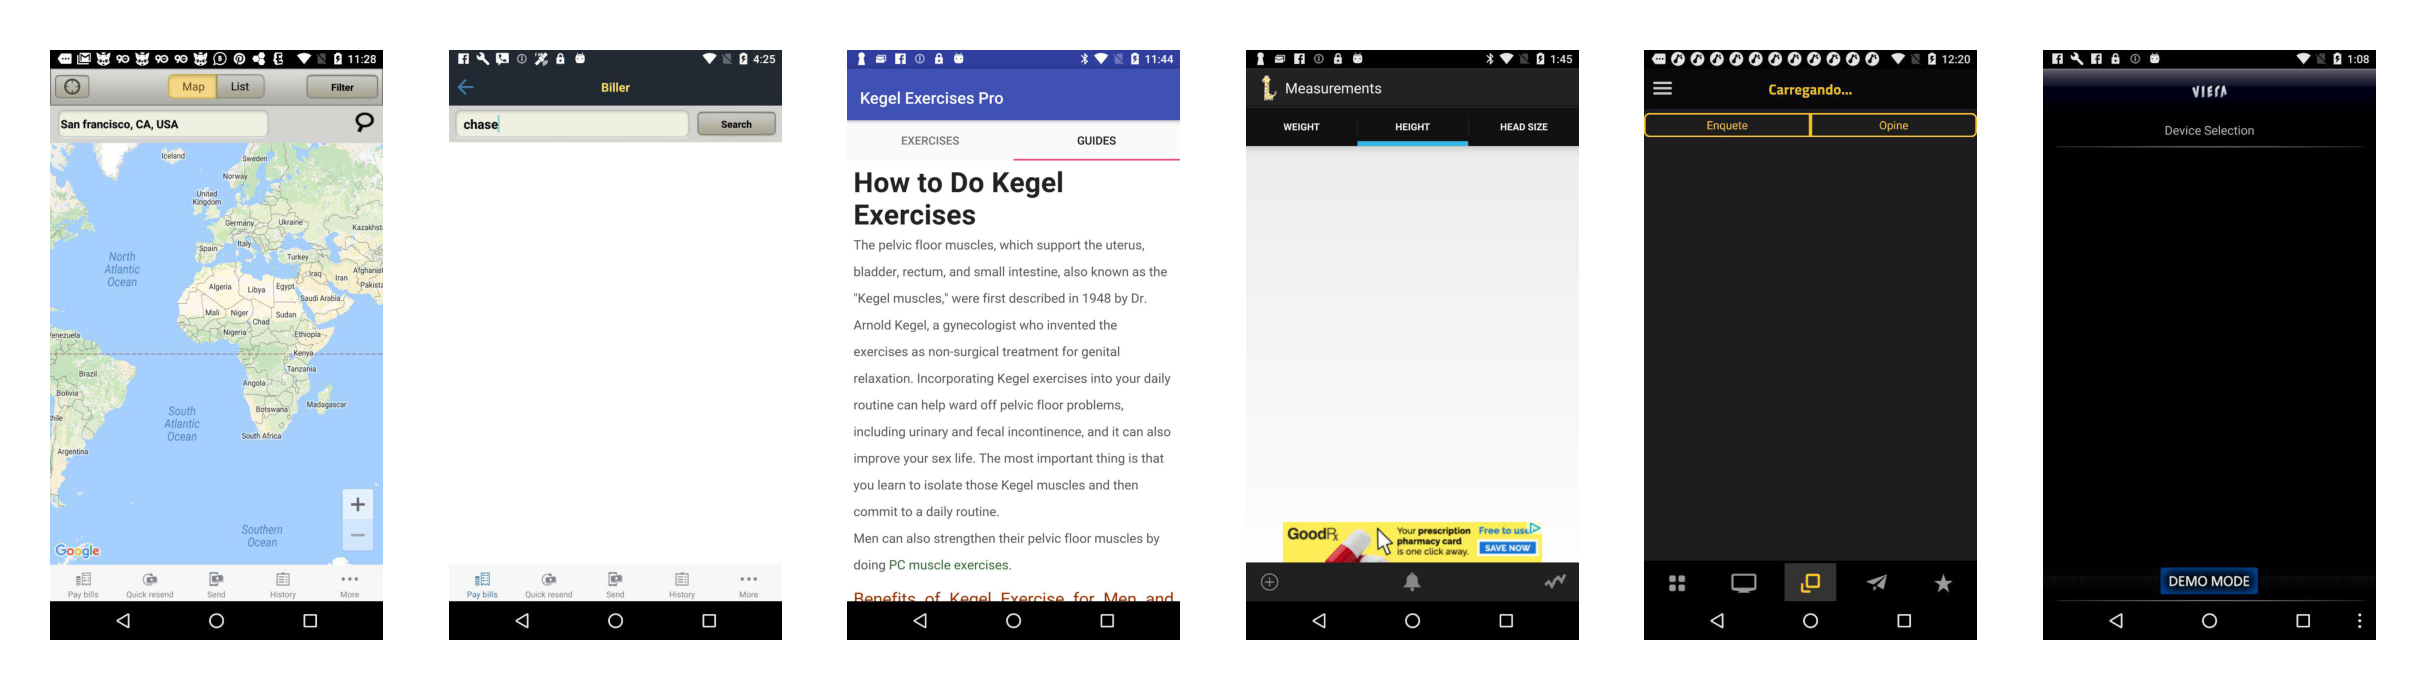

In [84]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# initialize and train NearestNeighbor model with the rico dataset
n_neighbors=6
neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=0.4)
neigh.fit(lay_emb)

# get the layout of the j index of found (popular) screenshots 
img_num = ui_indice
vecinos = neigh.kneighbors(lay_emb[img_num,:][np.newaxis], return_distance=True)

ui_vec=[]
for i in vecinos[1][0]:
    ui_vec.append(ui_index[i])
    pass

# shows the screenshots with the most similar layout
fig, ax = plt.subplots(1,n_neighbors)
fig.set_dpi(500)
print(vecinos)
print(ui_vec)
for j in range(len(ui_vec)):
    filename = os.path.join(rico_dataset, f"{ui_vec[j]}.jpg")
    img = mpimg.imread(filename)
    ax[j].imshow(img)
    ax[j].axis('off')

# saves the images
fig.savefig(os.path.join(cluster_examples_rico,f"cluster_from_{img_num}_{ui_vec[0]}.jpg"), dpi=fig.dpi)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


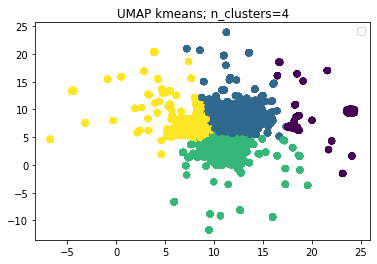

In [15]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=4)
# computes reduced embedding vectors
reduced_embeddings = reducer.fit_transform(lay_emb)

# apply k means
kmeans_n_clusters = 4
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(reduced_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)
plt.title(f"UMAP kmeans; n_clusters={kmeans_n_clusters}")
plt.legend()
plt.savefig(os.path.join(cluster_examples_rico, f"All embedding layouts - UMAP Kmeans~{kmeans_n_clusters}"))
plt.show()

save_labels = kmeans.labels_

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional

%matplotlib inline

for i in clusters_labels:
    # popular_finall_df["ui_id"].values
    clust_examples = get_random_popular_examples(save_labels, i, 8, popular_finall_df["ui_id"].values)
    #print(list(clust_examples))

    # display images
    fig, ax = plt.subplots(1,8)
    fig.set_dpi(500)
    lista=[]
    
    # testing and making sure the results are correct
    #for j in range(len(clust_examples)):
    #    saved_popular_tensors = os.path.join(os.getcwd(), "popular_folder_972")
    #    
    #    iembed = torch.load(os.path.join(saved_popular_tensors, f"{clust_examples[j]}.pt"))
    #    #gets numpy embeddings from the embeddings
    #    numpy_embeddings = ((iembed.detach()).numpy()).reshape(1,-1)
    #    reduced_emb = reducer.transform(numpy_embeddings)
    #    lista.append(kmeans.predict(reduced_emb)[0])
    
    
    print(lista)
    
    for j in range(len(clust_examples)):
        filename = os.path.join(rico_layout_dataset, f"{clust_examples[j]}.png")
        img = mpimg.imread(filename)
        ax[j].imshow(img)
        ax[j].axis('off')

    fig.savefig(os.path.join(cluster_examples,f"example{i}.jpg"), dpi=fig.dpi)

### 3.2 Screen2Vec model

In [42]:
# Generates the vector embeddings for an input screen
# net version decides 
def get_embedding_project(screen, ui_model, screen_model, layout_model, num_predictors, net_version):

    # uses the screen and obtains the data if similar to rico image?
    with open(screen) as f:
        rico_screen = load_rico_screen_dict(json.load(f))
    labeled_text = get_all_labeled_uis_from_rico_screen(rico_screen)

    bert = SentenceTransformer('bert-base-nli-mean-tokens')
    bert_size = 768

    ### 1. GUI COMPONENT EMBEDDER
    ## 1. UI MODEL - GUI element embedding model.
    # initializes the model
    loaded_ui_model = HiddenLabelPredictorModel(bert, bert_size, 16)
    loaded_ui_model.load_state_dict(torch.load(ui_model), strict=False)

    # obtains class and text of components from the layout of screenshot, and creates variable [text, class]
    ui_class = torch.tensor([UI[1] for UI in labeled_text])
    ui_text = [UI[0] for UI in labeled_text]

    # obtains ambedding for all components in the UI
    UI_embeddings = loaded_ui_model.model([ui_text, ui_class])
    #print("UI embeddings shape: ", UI_embeddings.shape)

    #avg_embedding = UI_embeddings.sum(dim=0)/len(labeled_text)

    ### 2.1 SCREEN HERARCHY - APP DESCRIPTION
    # gets description from app's google play metadata, if not, it leaves blank
    try:
        package_name = rico_screen.activity_name.split("/")[0]
        descr = get_app_description(package_name)
    except Exception as e:
        descr = ''

    # encodes description using BERT model - APP DESCRIPTION IN IMAGE
    descr_emb = torch.as_tensor(bert.encode([descr]), dtype=torch.float)
    
    ### 2.2 LAYOUT AUTOENCODER
    ## 3. LAYOUT MODEL
    # initializes and loads layout autoencoder, and encoding
    layout_autoencoder = LayoutAutoEncoder()
    layout_autoencoder.load_state_dict(torch.load(layout_model))
    layout_embedder = layout_autoencoder.enc

    # gets pixels from screen and encoded layout from screen sample
    screen_to_add = ScreenLayout(screen)
    screen_pixels = screen_to_add.pixels.flatten()
    encoded_layout = layout_embedder(torch.as_tensor(screen_pixels, dtype=torch.float).unsqueeze(0)).squeeze(0)


    if net_version in [0,2,6]:
        adus = 0
    else:
        # case where coordinates are part of UI rnn
        adus = 4
    if net_version in [0,1,6]:
        adss = 0
    else:
        # case where screen layout vec is used
        adss = 64
    if net_version in [0,1,2,3]:
        desc_size = 768
    else:
        # no description in training case
        desc_size = 0

    ### 2.3 
    # initializes and loads screen embedder from parameter
    # 2... SCREEN MODEL
    screen_embedder = Screen2Vec(bert_size, adus, adss, net_version)
    loaded_screen_model = TracePredictor(screen_embedder, net_version)
    loaded_screen_model.load_state_dict(torch.load(screen_model))


    if net_version in [1,3,4,5]:
        coords = torch.FloatTensor([labeled_text[x][2] for x in range(len(UI_embeddings))])
        UI_embeddings = torch.cat((UI_embeddings.cpu(),coords),dim=1)
    if net_version in [0,1,6]:
        screen_layout = None
    else: screen_layout = encoded_layout.unsqueeze(0).unsqueeze(0)
    
    #print("UI_embeddings shape: ", UI_embeddings.unsqueeze(1).unsqueeze(0).shape)
    #print("Description embedding: ", descr_emb.shape)
    #print("Screen layout shape: ", screen_layout.shape)
    # computes de Screen2Vec embedding using the GUI component embeddings, description embedding, and layout encoder.
    screen_emb = screen_embedder(UI_embeddings.unsqueeze(1).unsqueeze(0), descr_emb.unsqueeze(0), None, screen_layout, False)

    if descr_emb.size()[0] == 1:
        descr_emb = descr_emb.squeeze(0)
    return screen_emb[0][0]


def save_embeddings_array(array: [int], pre: int) -> [int]:
    """Computes the embedding vectors of the screenshot layouts named from a to b, 
       and saves them as ".pt" files at 'saved_tensors' folder."""
    
    not_found = []
    name = str(pre)+"_folder_"
    popular_folder = os.path.join(os.getcwd(), name)
    
    print(popular_folder)
    Path(popular_folder).mkdir(parents=True, exist_ok=True)
    for i in array:
        print(i)
        try:
        # gets and computes the layout embedding vector
            layout = os.path.join(rico_dataset, f"{i}.json")
            embedding = get_embedding_project(layout, gui_element_path, screen2vec_path, layout_encoder, 4, 4)

            # saves the tensor at "save_tensor"
            save_tensor = os.path.join(popular_folder, f"{i}.pt")
            torch.save(embedding, save_tensor)
        
        except FileNotFoundError:
            not_found.append(i)
        except RuntimeError:
            not_found.append(i)
    return not_found


def get_popular_embeddings(pop_path) -> ([int], [torch.Tensor]):
    """Gets the embedding vectors of the popular app's screenshots saved in the popular """
    
    found = []
    embeddings = []
    
    # loads the tensors at "saved_tensors" from a to b
    for i in range(0, 70000):
        try:
            iembed = os.path.join(pop_path, f"{i}.pt")
            embeddings.append(torch.load(iembed))
            found.append(i)
        except FileNotFoundError:
            #print(i)
            pass
    return (embeddings, found)

In [44]:
not_found_popular_layout = save_embeddings_array(ui_index, "ratings_score")

C:\Users\rober_abgp8xd\Desktop\canada-trabajo\cad-work\ratings_score_folder_
172
173
174
175
176
177
1070
1071
1072
1073
1074
1075
1076
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1118
1119
1279
1280
1281
1282
1283
1690
1691
1777
1778
1779
1780
1781
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2218
2219
2220
2221
2222
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2571
2572
2573
2574
2576
2579
2959
2960
2961
2962
2963
2964
2965
2966
2967
3207
3208
3209
3210
3211
3212
3213
3457
3458
3459
3460
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3719
3720
3721
3722
3723
3724
3725
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4227
4228
4229
4230
4310
4311
5046
5047
5331
5332
5333
5334
5335

48500
48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48854
48855
48856
48857
48858
48859
48993
48994
48995
48996
49053
49054
49055
49056
49057
49058
49059
49060
49087
49088
49089
49090
49091
49092
49184
49185
49186
49515
49516
49517
49518
49519
49520
49521
49522
49523
49524
49525
49526
49527
49528
49529
49530
49531
50195
50196
50197
50198
50199
50200
50201
50202
50203
50682
50719
50720
50721
50722
50723
50724
50725
50726
50727
50728
51385
51386
51387
51388
51389
51390
51391
51392
51393
51394
51395
51396
51397
51398
51399
51614
47434
47435
47436
47437
47438
51908
51909
51910
51911
51912
52213
52349
52350
52351
52352
52353
52354
52355
52356
52357
52358
52359
52360
52361
52362
52363
52364
52365
52366
52367
52368
52369
52370
52371
52372
52422
52423
52424
52426
52427
52428
52513
52514
52515
52516
52517
52518
52519
52520
52555
52556
52557
52558
52559
52560
52561
52562
48231
48232
48233
48234
48235
48236
48237
52960
52961
52962
52963
52964
52965
52966
52967
52968
5296

In [46]:
popular_lay_emb_path = os.path.join(os.getcwd(), "computed_tensors", "ratings_score_tensors")
popular_lay_embs, found = get_popular_embeddings(popular_lay_emb_path)

In [52]:
pop_screen_embed = torch.stack(popular_lay_embs, dim=0)
# gets numpy embeddings from the embeddings
np_pop_embs = pop_screen_embed.detach().numpy().squeeze()

### 3.3 CLAY Data-trained Model

In [16]:
clay_index = []
xml_files = os.path.join(os.getcwd(), "xml-full")

files = os.listdir(xml_files)

for i in files:
    clay_index.append(int(i.replace(".xml","").strip()))
clay_index.sort()

In [17]:
rating_score_emb = os.path.join(os.getcwd(), "s2v_code", "embeddings", "clay_model_layout_embeddings.json")

lista_emb=[]
with open(rating_score_emb) as f:
    data = json.load(f)
    for i in clay_index:
        lista_emb.append(data[str(i)])

rating_score_emb = np.array(lista_emb)
rating_score_emb = rating_score_emb.reshape(-1,64)
print(rating_score_emb.shape)

(59555, 64)


In [32]:
b=np.zeros(64)
indexess = list(np.where(np.all(rating_score_emb == b,axis=0))[0])

res_list = [clay_index[i] for i in indexess]
print(indexess)
print(res_list)

[1, 4, 6, 18, 23, 26, 29, 31, 39, 42, 44, 48, 49, 53]
[3, 6, 8, 22, 28, 32, 35, 38, 50, 53, 55, 60, 61, 65]


In [73]:
clayy=808
clay_indice =  clay_index.index(clayy)
print(clay_indice)

692


(array([[0.        , 0.30367561, 0.87806403, 0.96850135, 1.06729961,
        1.10139482]]), array([[  692, 55626, 24263,  8260, 16253, 21625]], dtype=int64))
[808, 67313, 29453, 9643, 19514, 26186]


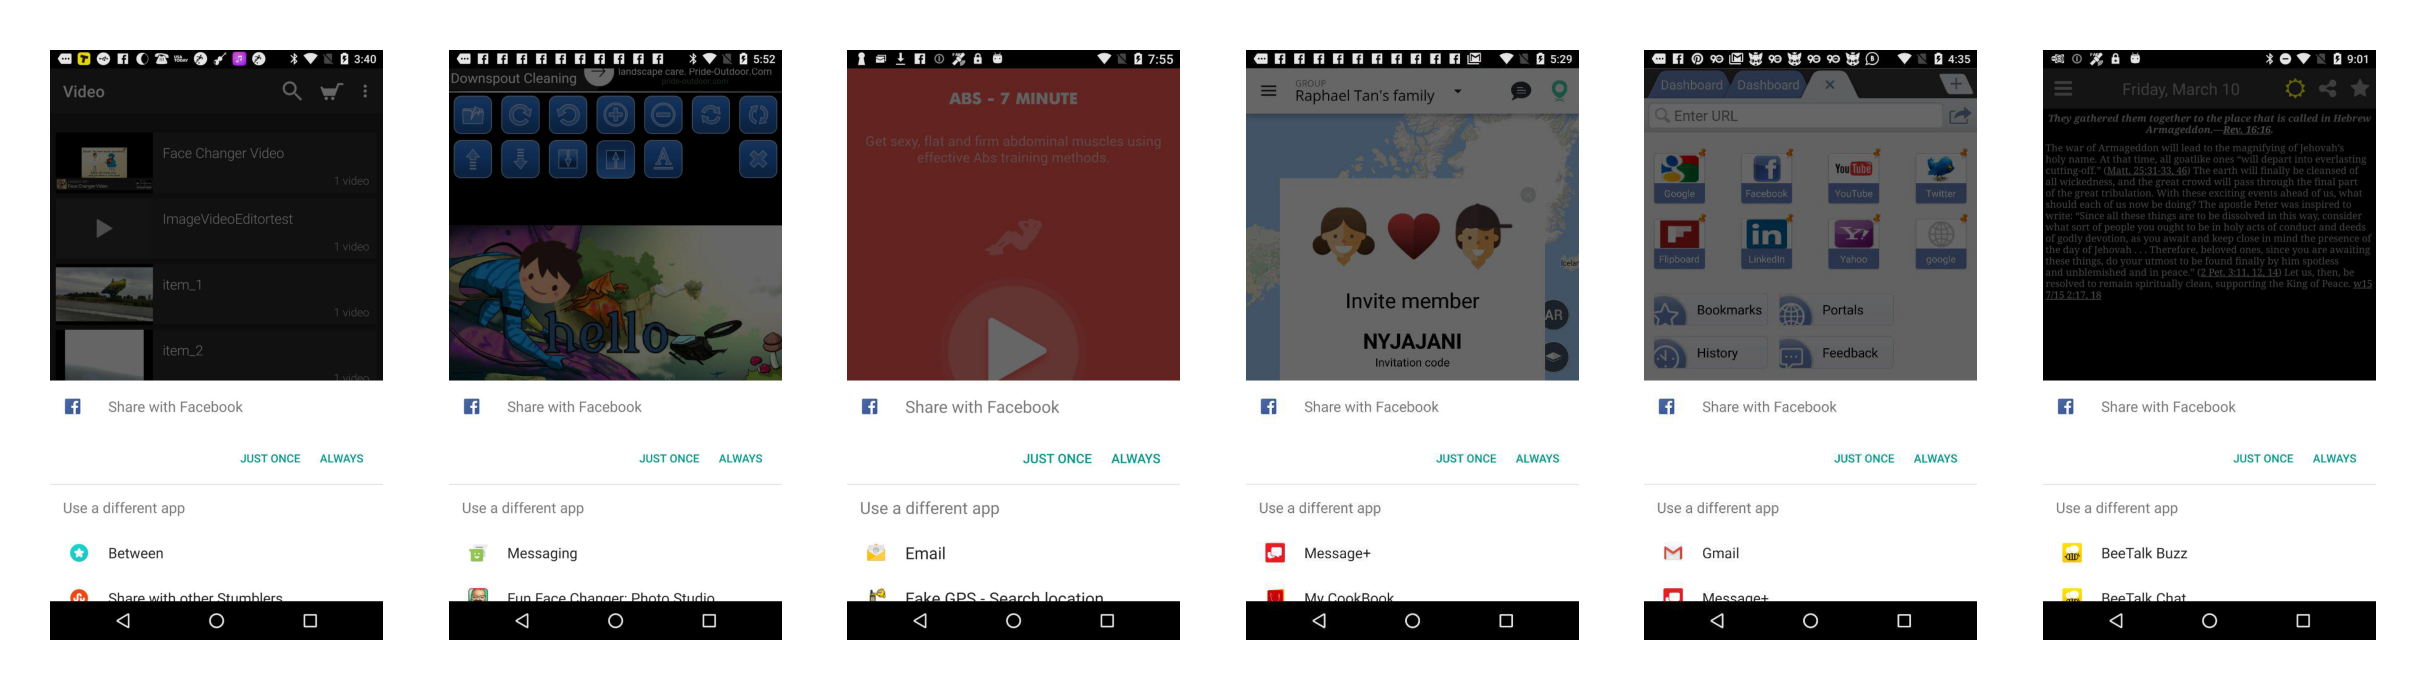

In [74]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams


# initialize and train NearestNeighbor model with the rico dataset
n_neighbors=6
neigh = NearestNeighbors(n_neighbors=n_neighbors, radius=0.4)
neigh.fit(rating_score_emb)

# get the layout of the j index of found (popular) screenshots 
img_num = clay_indice
vecinos = neigh.kneighbors(rating_score_emb[img_num,:][np.newaxis], return_distance=True)

ui_vec=[]
for i in vecinos[1][0]:
    ui_vec.append(clay_index[i])
    pass

# shows the screenshots with the most similar layout
fig, ax = plt.subplots(1,n_neighbors)
fig.set_dpi(500)
print(vecinos)
print(ui_vec)
for j in range(len(ui_vec)):
    filename = os.path.join(rico_dataset, f"{ui_vec[j]}.jpg")
    img = mpimg.imread(filename)
    ax[j].imshow(img)
    ax[j].axis('off')

# saves the images
fig.savefig(os.path.join(clay_model_cluster_examples,f"cluster_from_{img_num}_{ui_vec[0]}.jpg"), dpi=fig.dpi)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


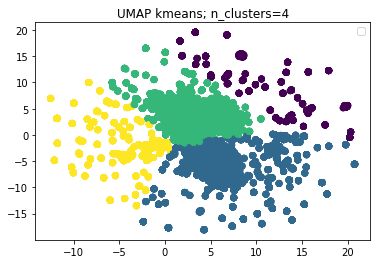

In [72]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=4)
# computes reduced embedding vectors
reduced_embeddings = reducer.fit_transform(rating_score_emb)

# apply k means
kmeans_n_clusters = 4
kmeans = KMeans(n_clusters = kmeans_n_clusters, n_init = 20, random_state = 10)
kmeans.fit(reduced_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)
plt.title(f"UMAP kmeans; n_clusters={kmeans_n_clusters}")
plt.legend()
plt.savefig(os.path.join(clay_model_cluster_examples, f"CLAY trained model - UMAP Kmeans~{kmeans_n_clusters}"))
plt.show()

save_labels = kmeans.labels_ 

## 2. Popular App's Screenshots

In [29]:
lay_embs_unord = np.load(layout_embedding_csv)
lay_emb = np.zeros((len(found), 64), dtype=int)

f = open(ui_names_csv)
lay_index = json.load(f)["ui_names"]
j=0
for i in found:
    try:
        k = lay_index.index(str(i)+".png")
        i_emb = lay_embs_unord[k,:]
    except ValueError:
        i_emb = np.zeros((64,), dtype=int)
    lay_emb[j,:] = i_emb
    j+=1
    

f.close()
print(lay_emb.shape)

NameError: name 'found' is not defined